# Supervised Learning for Heart Rate Prediction

This notebook explores supervised machine learning techniques to predict heart rate values 
based on other vital signs. The analysis follows these key steps:

1. Data Preparation
   - Load preprocessed data from unsupervised analysis
   - Create feature matrix with vital signs and engineered features
   - Scale and transform features using PCA

2. Feature Engineering
   - Apply dimensionality reduction (PCA)
   - Add anomaly detection scores
   - Include autoencoder features

3. Model Development
   - Train Random Forest base model
   - Compare multiple model architectures
   - Implement stacking ensemble

4. Evaluation & Analysis
   - Assess model performance metrics
   - Analyze feature importance
   - Perform error analysis
   - Cross-validate results

The goal is to build a reliable predictor for heart rate values using other vital measurements,
which could help detect anomalous readings or fill missing data.


In [30]:
# Import required libraries and utilities
# Data handling & visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Scikit-learn components
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import (
    RandomForestRegressor,
    IsolationForest,
    GradientBoostingRegressor,
    StackingRegressor  # For stacked model analysis
)
from sklearn.linear_model import (
    LassoCV,
    RidgeCV,
    LinearRegression
)
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    mean_absolute_error,
    make_scorer
)
from sklearn.model_selection import (
    train_test_split,
    cross_validate,
    cross_val_score,
    KFold
)
from sklearn.svm import (
    OneClassSVM,
    SVR
)
from sklearn.feature_selection import RFECV

# Deep learning with TensorFlow
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Custom utilities
from setup_utils import load_intermediate_data, plr, save_intermediate_data


In [3]:
"""
Data Preparation
---------------
Loads preprocessed dataset from unsupervised analysis and prepares features for modeling.

Process:
1. Load preprocessed data with scaled features
2. Create feature matrix and target variable
3. Split data into train/test sets
4. Prepare cross-validation folds

Features used:
- Scaled vital signs from previous analysis
- UMAP projections
- Outlier detection scores
"""

# Load preprocessed data
df = load_intermediate_data('data/intermediate_unsupervised.csv')

# Define feature sets (using already scaled vital signs)
non_hr_vitals = ['resp_rate', 'mbp', 'temperature', 'spo2']
feature_cols = (
    non_hr_vitals +  # Basic vital signs (already scaled)
    ['umap_x', 'umap_y'] +  # Dimensionality reduction features
    ['kmeans_outlier', 'dbscan_outlier', 'umap_dbscan_outlier']  # Outlier indicators
)

# Prepare features and target
X = df[feature_cols]
y = df['heart_rate']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

In [4]:
"""
Feature Engineering: PCA Transformation
------------------------------------
Applies PCA to already-scaled features for dimensionality reduction.

Process:
1. Apply PCA to scaled features from unsupervised analysis
2. Determine optimal number of components
3. Transform data and add PCA features
4. Combine with original feature set

Note: Input features are already scaled from unsupervised analysis,
      so no additional scaling is needed before PCA.
"""

# Apply PCA directly to scaled features
pca = PCA()
X_pca = pca.fit_transform(X)

# Find optimal components for 95% variance
n_components = np.argmax(pca.explained_variance_ratio_.cumsum() > 0.95) + 1
print(f"Number of components explaining 95% variance: {n_components}")

# Add PCA components to feature set
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)
for i in range(n_components):
    X[f'pca_{i}'] = X_pca[:, i]

# Display variance explained by components
cumulative_variance = pca.explained_variance_ratio_.cumsum()
print("\nVariance Explained:")
for i, var in enumerate(cumulative_variance):
    print(f"Components 1-{i+1}: {var:.3%}")

Number of components explaining 95% variance: 3

Variance Explained:
Components 1-1: 82.382%
Components 1-2: 93.792%
Components 1-3: 97.199%


C:\Users\steve\AppData\Local\Temp\ipykernel_26432\3754747235.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f'pca_{i}'] = X_pca[:, i]
C:\Users\steve\AppData\Local\Temp\ipykernel_26432\3754747235.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f'pca_{i}'] = X_pca[:, i]
C:\Users\steve\AppData\Local\Temp\ipykernel_26432\3754747235.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [10]:
"""
Feature Engineering: Anomaly Detection
----------------------------------
1. Apply Isolation Forest and One-Class SVM
2. Generate anomaly scores
3. Combine scores for comprehensive anomaly detection
"""

# Generate anomaly scores using multiple methods
iso_forest = IsolationForest(random_state=42)
ocsvm = OneClassSVM()

X['isolation_forest_score'] = iso_forest.fit_predict(X)
X['ocsvm_score'] = ocsvm.fit_predict(X)

# Combine anomaly scores
X['combined_anomaly_score'] = (
    X['isolation_forest_score'] + 
    X['ocsvm_score']
)

C:\Users\steve\AppData\Local\Temp\ipykernel_26432\3447829049.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['isolation_forest_score'] = iso_forest.fit_predict(X)
C:\Users\steve\AppData\Local\Temp\ipykernel_26432\3447829049.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['ocsvm_score'] = ocsvm.fit_predict(X)
C:\Users\steve\AppData\Local\Temp\ipykernel_26432\3447829049.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

In [15]:
"""
Feature Engineering: Autoencoder Features
-------------------------------------
1. Build autoencoder architecture
2. Train model to learn compressed representation
3. Extract encoded features
4. Add to feature set
"""

# Configure autoencoder dimensions
input_dim = X.shape[1]
encoding_dim = min(3, input_dim // 2)

# Build and train autoencoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim * 2, activation='relu')(input_layer)
encoded = Dense(encoding_dim, activation='relu')(encoded)
decoded = Dense(encoding_dim * 2, activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(input_layer, decoded)
encoder = Model(input_layer, encoded)

# Train and extract features
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X, X, 
                epochs=50, 
                batch_size=32, 
                shuffle=True, 
                verbose=0)

# Add encoded features to dataset
X_encoded = encoder.predict(X)
for i in range(encoding_dim):
    X[f'ae_feature_{i}'] = X_encoded[:, i]

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [16]:
"""
Random Forest Model Development
---------------
1. Prepare final feature set
2. Split data into train/test sets
3. Train Random Forest model with optimized parameters
4. Generate predictions
"""

# Prepare final feature matrix
feature_cols = [col for col in X.columns if col != 'heart_rate']
X_final = X[feature_cols]
y = df['heart_rate']

# Split data and train model
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42
)

model = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Model Performance Metrics:
Mean Squared Error (MSE): 47.14
Root Mean Squared Error (RMSE): 6.87
Mean Absolute Error (MAE): 5.04
R-squared Score (R²): 0.79


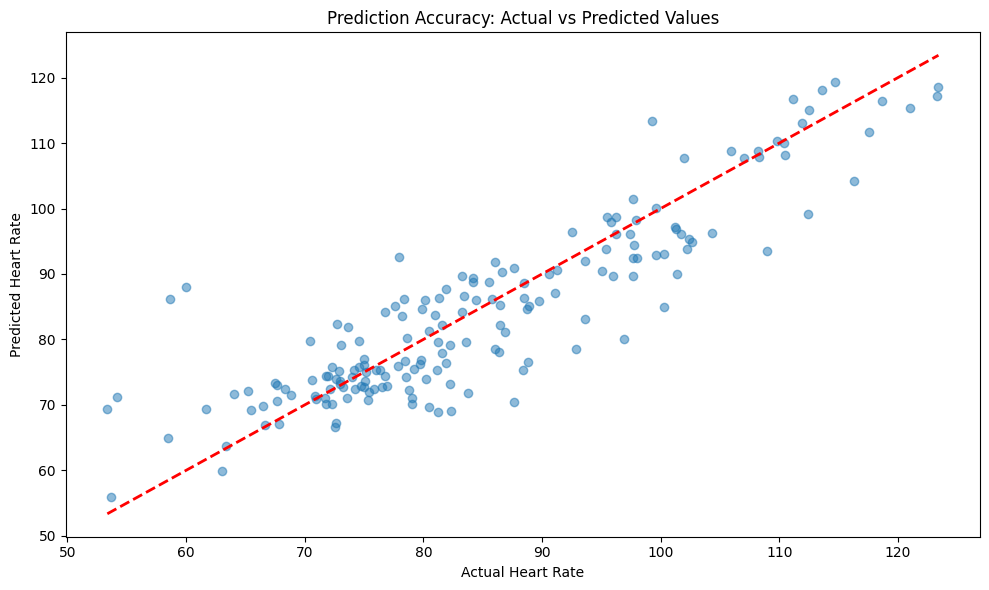

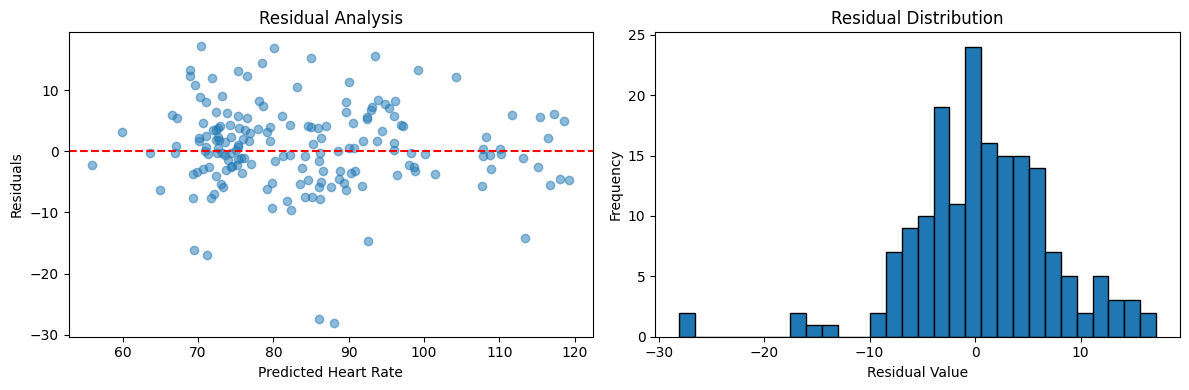

In [20]:
"""
Model Performance Analysis
------------------------
1. Calculate key regression metrics
2. Visualize predictions vs actual values
3. Analyze residuals distribution
4. Generate performance summary
"""

# Calculate comprehensive performance metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Performance Metrics:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared Score (R²): {r2:.2f}")

# Visualize prediction accuracy
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], 
         [y_test.min(), y_test.max()], 
         'r--', lw=2)
plt.xlabel('Actual Heart Rate')
plt.ylabel('Predicted Heart Rate')
plt.title('Prediction Accuracy: Actual vs Predicted Values')
plt.tight_layout()
plt.show()

# Analyze residuals
residuals = y_test - y_pred
plt.figure(figsize=(12, 4))

# Residual scatter plot
plt.subplot(121)
plt.scatter(y_pred, residuals, alpha=0.5)
plt.xlabel('Predicted Heart Rate')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.axhline(y=0, color='r', linestyle='--')

# Residual distribution
plt.subplot(122)
plt.hist(residuals, bins=30, edgecolor='black')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.title('Residual Distribution')
plt.tight_layout()
plt.show()

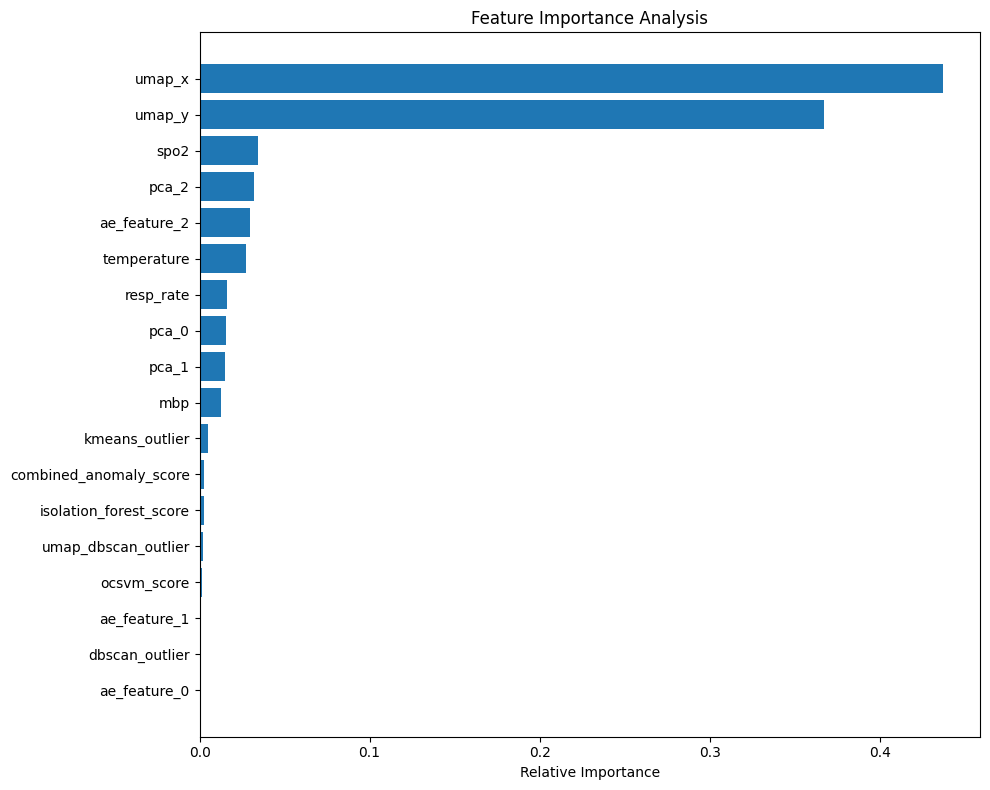


Top 10 Most Influential Features:
     feature  importance
         mbp    0.012866
       pca_1    0.015015
       pca_0    0.015283
   resp_rate    0.016182
 temperature    0.027510
ae_feature_2    0.029429
       pca_2    0.031918
        spo2    0.034316
      umap_y    0.367460
      umap_x    0.437158


In [21]:
"""
Feature Importance Analysis
-------------------------
1. Calculate feature importance scores
2. Visualize relative importance
3. Identify top contributing features
4. Generate feature importance summary
"""

# Generate feature importance ranking
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=True)

# Visualize feature importance
plt.figure(figsize=(10, 8))
plt.barh(feature_importance['feature'], 
         feature_importance['importance'])
plt.xlabel('Relative Importance')
plt.title('Feature Importance Analysis')
plt.tight_layout()
plt.show()

# Display top influential features
print("\nTop 10 Most Influential Features:")
print(feature_importance.tail(10).to_string(index=False))

Cross-validation Performance:
Individual fold R² scores: [0.80149192 0.785496   0.8586663  0.79240864 0.84622636]
Mean R² score: 0.817 (±0.060)


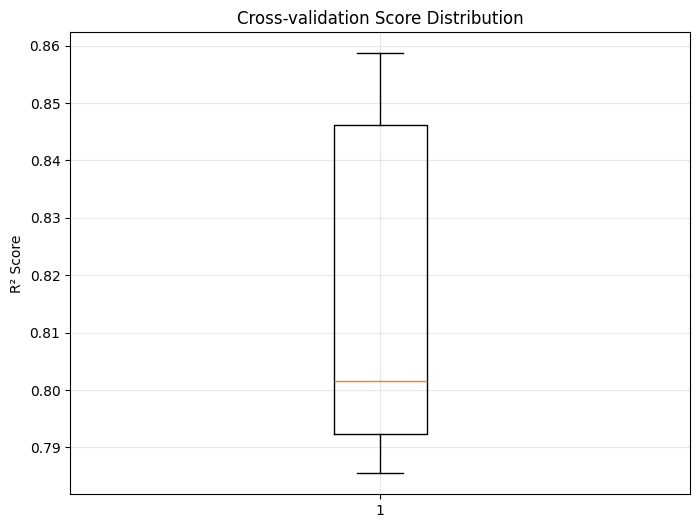

In [25]:
"""
Cross-validation Analysis
-----------------------
1. Perform k-fold cross-validation
2. Calculate performance stability
3. Visualize score distribution
4. Assess model reliability
"""

# Configure and perform cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_final, y, cv=cv, scoring='r2')

# Display cross-validation results
print("Cross-validation Performance:")
print(f"Individual fold R² scores: {cv_scores}")
print(f"Mean R² score: {cv_scores.mean():.3f} (±{cv_scores.std() * 2:.3f})")

# Visualize score distribution
plt.figure(figsize=(8, 6))
plt.boxplot(cv_scores)
plt.title('Cross-validation Score Distribution')
plt.ylabel('R² Score')
plt.grid(True, alpha=0.3)
plt.show()

c:\Users\steve\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 171.7859182566317, tolerance: 12.86221406856613
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\steve\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1683.364075865029, tolerance: 12.86221406856613
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\steve\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3622.502214632921, tolerance: 12.86221406856613
  model = cd_fast.enet_coordinate_descent_gram(
c:\U

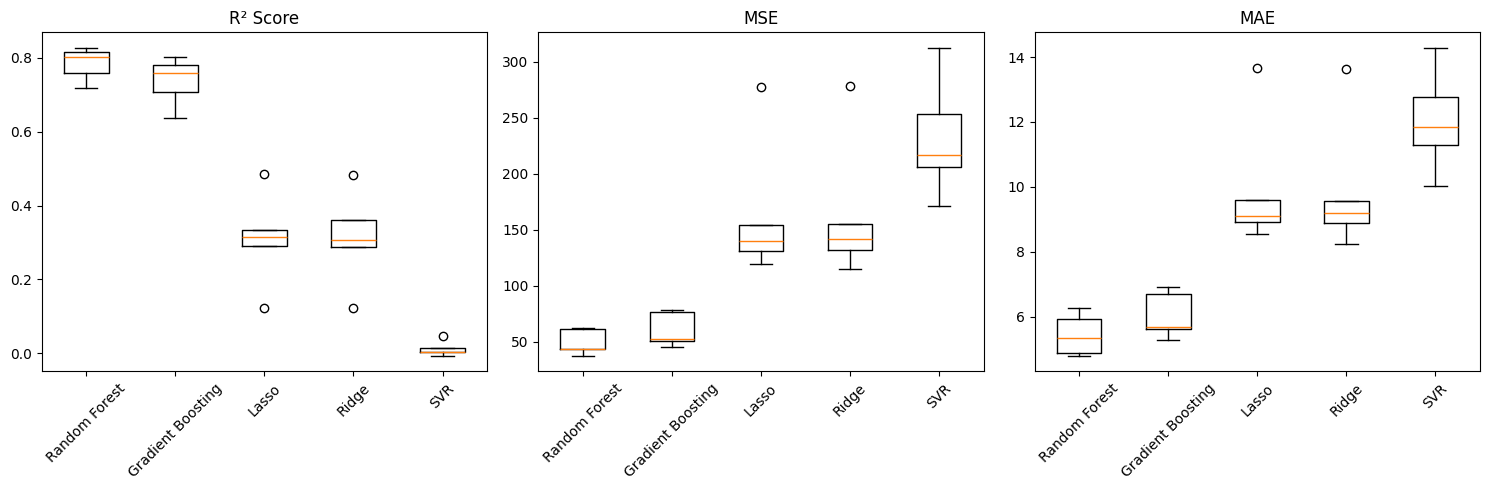

In [31]:
"""
Model Comparison Analysis
-----------------------
1. Compare multiple regression algorithms
2. Evaluate performance metrics
3. Visualize comparative results
4. Identify best performing model
"""

# Define model variants for comparison
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Lasso': LassoCV(cv=5),
    'Ridge': RidgeCV(cv=5),
    'SVR': SVR(kernel='rbf')
}

# Configure evaluation metrics
scoring = {
    'r2': 'r2',
    'mse': make_scorer(mean_squared_error),
    'mae': make_scorer(mean_absolute_error)
}

# Perform comparative analysis
results = {}
for name, model in models.items():
    cv_results = cross_validate(model, X, y, 
                              scoring=scoring, 
                              cv=5, 
                              return_train_score=True)
    results[name] = cv_results

# Visualize comparison results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
metrics = ['test_r2', 'test_mse', 'test_mae']
titles = ['R² Score', 'MSE', 'MAE']

for ax, metric, title in zip(axes, metrics, titles):
    scores = [results[model][metric] for model in results.keys()]
    ax.boxplot(scores, labels=list(results.keys()))
    ax.set_title(title)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Stacked Model Performance:
R² Score: 0.790
RMSE: 6.861
MAE: 5.078


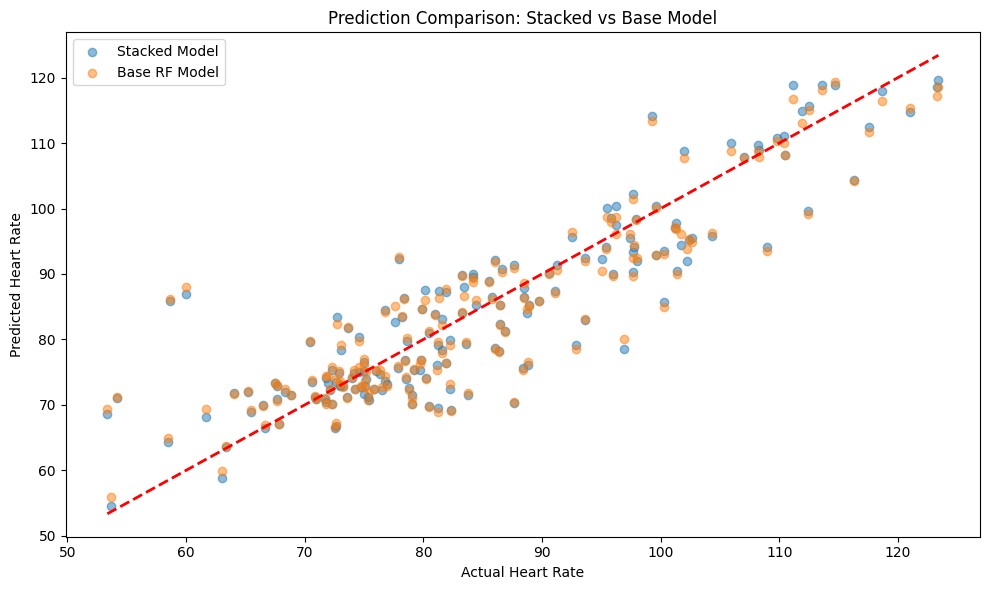


Model Improvement:
RMSE Improvement: 0.08%


In [32]:
"""
Stacked Model Analysis
--------------------
1. Create ensemble of base models
2. Configure stacking regressor
3. Train stacked model
4. Compare performance with base models

The stacking approach combines multiple models to leverage their individual strengths:
- Random Forest: Handles non-linear relationships and interactions
- Gradient Boosting: Focuses on difficult-to-predict cases
- Ridge: Provides regularized linear predictions
"""

# Define base models for stacking
base_models = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingRegressor(random_state=42)),
    ('ridge', RidgeCV())
]

# Create and configure stacked model
stacked_model = StackingRegressor(
    estimators=base_models,
    final_estimator=LassoCV(),  # Meta-learner with feature selection
    cv=5  # 5-fold cross-validation for base predictions
)

# Train stacked model
stacked_model.fit(X_train, y_train)
stacked_pred = stacked_model.predict(X_test)

# Compare performance metrics
print("Stacked Model Performance:")
print(f"R² Score: {r2_score(y_test, stacked_pred):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, stacked_pred)):.3f}")
print(f"MAE: {mean_absolute_error(y_test, stacked_pred):.3f}")

# Visualize comparison with base model
plt.figure(figsize=(10, 6))
plt.scatter(y_test, stacked_pred, alpha=0.5, label='Stacked Model')
plt.scatter(y_test, y_pred, alpha=0.5, label='Base RF Model')
plt.plot([y_test.min(), y_test.max()], 
         [y_test.min(), y_test.max()], 
         'r--', lw=2)
plt.xlabel('Actual Heart Rate')
plt.ylabel('Predicted Heart Rate')
plt.title('Prediction Comparison: Stacked vs Base Model')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate improvement percentage
base_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
stacked_rmse = np.sqrt(mean_squared_error(y_test, stacked_pred))
improvement = ((base_rmse - stacked_rmse) / base_rmse) * 100

print(f"\nModel Improvement:")
print(f"RMSE Improvement: {improvement:.2f}%")

Error Analysis for Top 5 Important Features:
---------------------------------------------

Analyzing: ae_feature_2


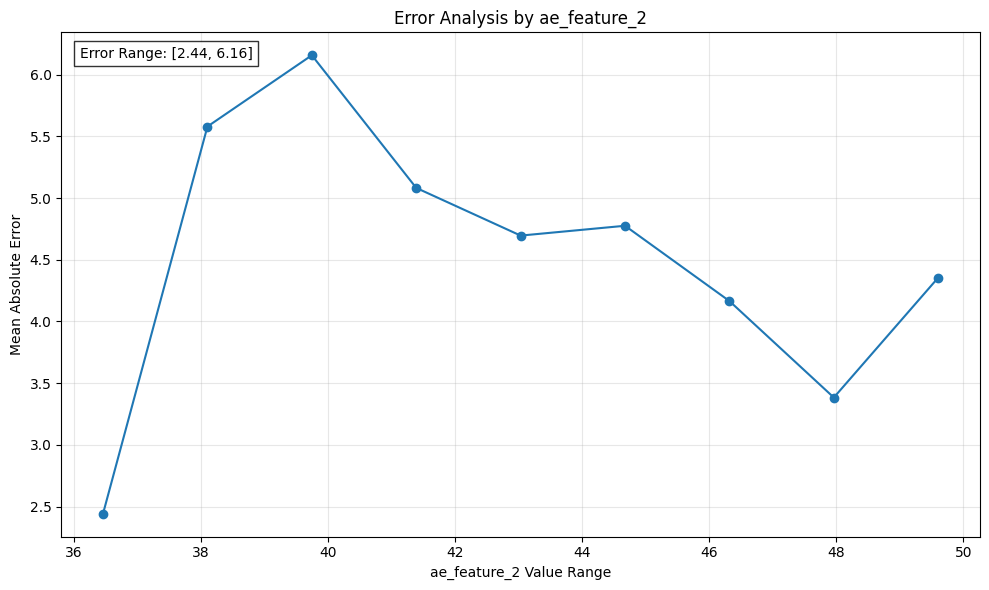

Mean Error in Bottom Quartile: 4.99
Mean Error in Top Quartile: 4.02

Analyzing: pca_2


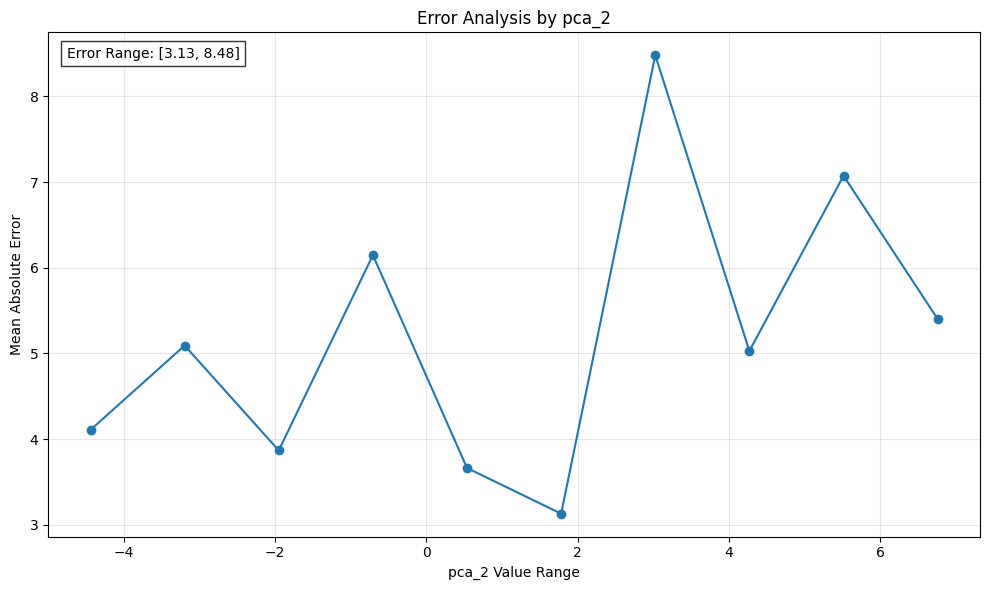

Mean Error in Bottom Quartile: 3.94
Mean Error in Top Quartile: 6.63

Analyzing: spo2


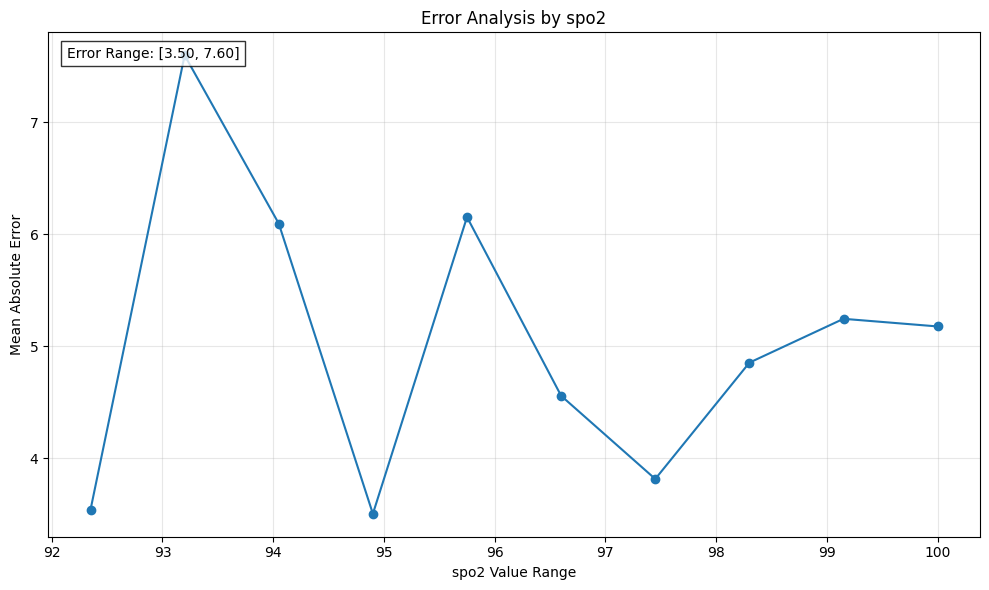

Mean Error in Bottom Quartile: 6.02
Mean Error in Top Quartile: 5.53

Analyzing: umap_y


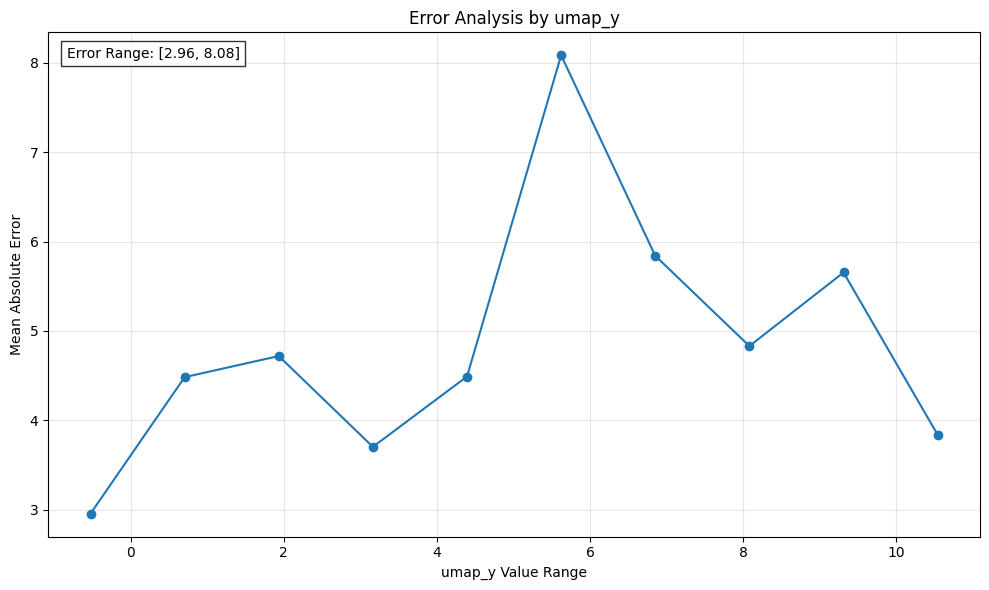

Mean Error in Bottom Quartile: 3.96
Mean Error in Top Quartile: 5.28

Analyzing: umap_x


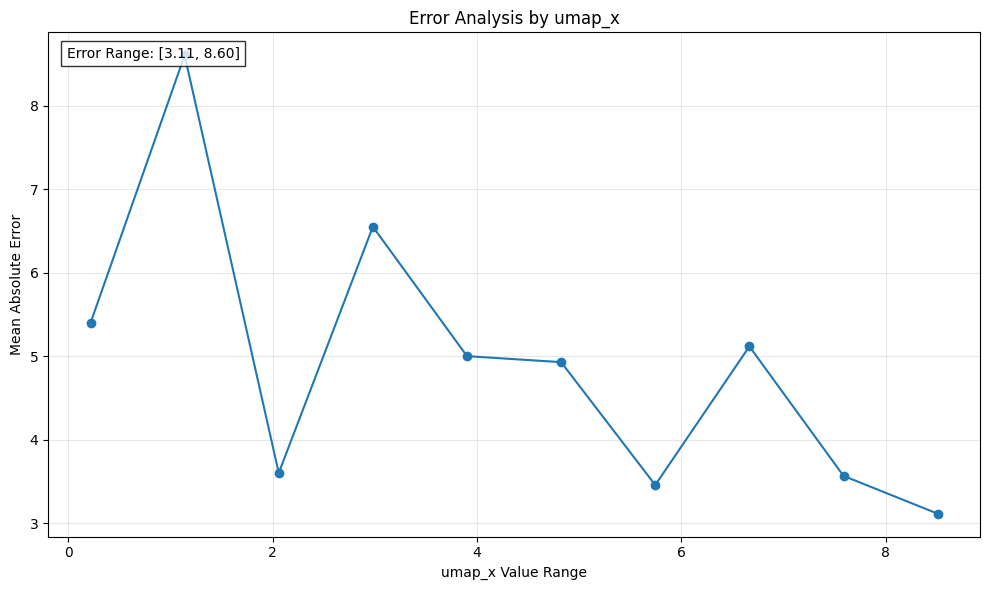

Mean Error in Bottom Quartile: 6.49
Mean Error in Top Quartile: 4.04


In [33]:
"""
Error Analysis by Feature Range
----------------------------
1. Analyze prediction errors across feature value ranges
2. Identify potential problematic regions
3. Visualize error distributions by feature
4. Detect feature-specific prediction biases

This analysis helps understand:
- Where the model performs well/poorly across feature ranges
- Potential non-linear relationships not captured
- Feature-specific prediction challenges
"""

def plot_error_by_feature(feature_name, X_test, y_test, y_pred, bins=10):
    """
    Analyze and visualize prediction errors across feature value ranges.
    
    Args:
        feature_name (str): Name of the feature to analyze
        X_test (DataFrame): Test feature set
        y_test (Series): True target values
        y_pred (array): Model predictions
        bins (int): Number of bins for error aggregation
    """
    feature_vals = X_test[feature_name]
    errors = np.abs(y_test - y_pred)
    
    # Create bins and calculate mean error for each bin
    bins = np.linspace(feature_vals.min(), feature_vals.max(), bins+1)
    digitized = np.digitize(feature_vals, bins)
    mean_errors = [errors[digitized == i].mean() for i in range(1, len(bins))]
    
    # Plot error distribution
    plt.figure(figsize=(10, 6))
    plt.plot(bins[1:], mean_errors, marker='o')
    plt.xlabel(f'{feature_name} Value Range')
    plt.ylabel('Mean Absolute Error')
    plt.title(f'Error Analysis by {feature_name}')
    plt.grid(True, alpha=0.3)
    
    # Add error range annotation
    plt.annotate(f'Error Range: [{min(mean_errors):.2f}, {max(mean_errors):.2f}]',
                xy=(0.02, 0.95), xycoords='axes fraction',
                bbox=dict(facecolor='white', alpha=0.8))
    plt.tight_layout()
    plt.show()

# Analyze errors for most important features
important_features = feature_importance.tail(5)['feature'].values
print("Error Analysis for Top 5 Important Features:")
print("-" * 45)

for feature in important_features:
    print(f"\nAnalyzing: {feature}")
    plot_error_by_feature(feature, X_test, y_test, y_pred)
    
    # Calculate summary statistics for errors in extreme ranges
    feature_vals = X_test[feature]
    errors = np.abs(y_test - y_pred)
    
    # Analyze errors in bottom and top quartiles
    q1, q3 = np.percentile(feature_vals, [25, 75])
    bottom_quartile_error = errors[feature_vals <= q1].mean()
    top_quartile_error = errors[feature_vals >= q3].mean()
    
    print(f"Mean Error in Bottom Quartile: {bottom_quartile_error:.2f}")
    print(f"Mean Error in Top Quartile: {top_quartile_error:.2f}")

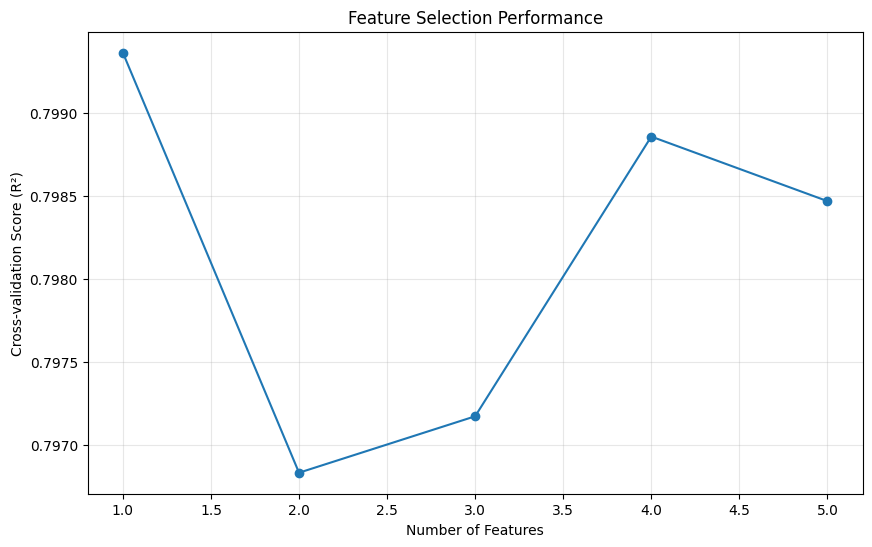


Optimal feature count: 5

Selected features:
- resp_rate
- mbp
- spo2
- umap_x
- umap_y

Feature Ranking:
               Feature  Ranking
0            resp_rate        1
1                  mbp        1
3                 spo2        1
4               umap_x        1
5               umap_y        1
2          temperature        2
6       kmeans_outlier        3
8  umap_dbscan_outlier        4
7       dbscan_outlier        5


In [35]:
"""
Feature Selection Analysis
------------------------
1. Perform recursive feature elimination
2. Identify optimal feature subset
3. Evaluate selection stability
4. Generate feature ranking

Process:
- Uses cross-validation to assess feature importance
- Recursively eliminates least important features
- Identifies optimal feature count
- Ranks features by selection order
"""

# Configure feature selection
base_features = [
    'resp_rate', 'mbp', 'temperature', 'spo2',  # Basic vitals
    'umap_x', 'umap_y',                         # UMAP projections
    'kmeans_outlier', 'dbscan_outlier',         # Outlier indicators
    'umap_dbscan_outlier'                       # Combined outlier detection
]
X_select = X[base_features]

# Initialize RFECV with Random Forest estimator
rfecv = RFECV(
    estimator=RandomForestRegressor(random_state=42),
    step=1,
    cv=5,
    scoring='r2',
    min_features_to_select=5
)

# Perform feature selection
rfecv.fit(X_select, y)

# Visualize selection scores
plt.figure(figsize=(10, 6))
plt.plot(
    range(1, len(rfecv.cv_results_['mean_test_score']) + 1),
    rfecv.cv_results_['mean_test_score'],
    marker='o'
)
plt.xlabel('Number of Features')
plt.ylabel('Cross-validation Score (R²)')
plt.title('Feature Selection Performance')
plt.grid(True, alpha=0.3)
plt.show()

# Display selection results
print(f"\nOptimal feature count: {rfecv.n_features_}")
selected_features = np.array(base_features)[rfecv.support_]
print("\nSelected features:")
for feat in selected_features:
    print(f"- {feat}")

# Generate feature ranking
feature_ranking = pd.DataFrame({
    'Feature': base_features,
    'Ranking': rfecv.ranking_
}).sort_values('Ranking')
print("\nFeature Ranking:")
print(feature_ranking)

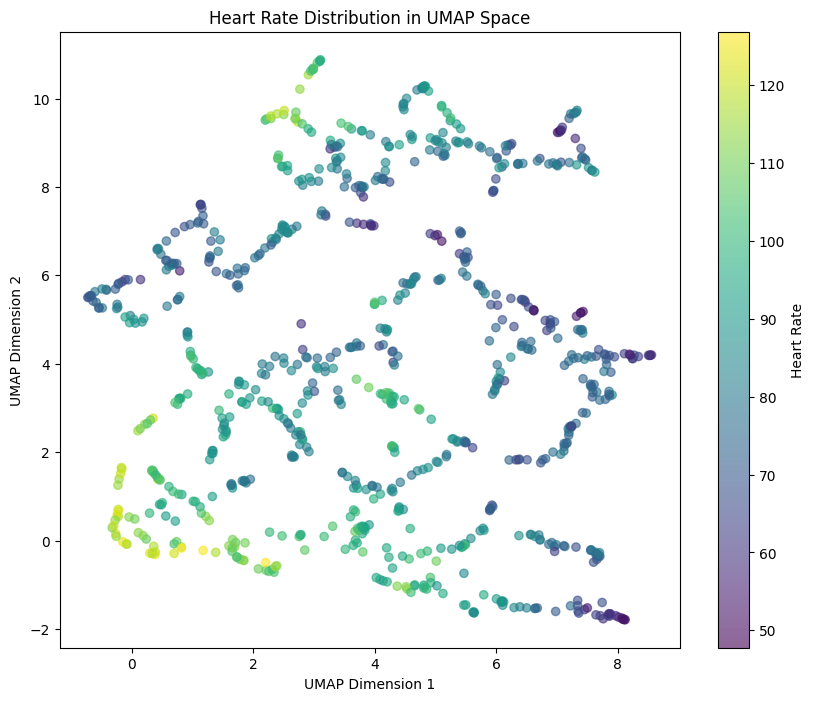

Feature Selection Insights:
-------------------------
Direct Physiological Measurements:
- Respiratory Rate: Direct cardiopulmonary relationship
- Mean Blood Pressure: Cardiovascular system indicator
- SpO2: Oxygen saturation correlation

Derived UMAP Features:
- UMAP_X: Primary non-linear vital pattern
- UMAP_Y: Secondary non-linear vital pattern

Less Important Features:
- Temperature: Less direct relationship
- Outlier indicators: Useful for anomaly detection but less for prediction


In [36]:
"""
UMAP Feature Interpretation
------------------------
Analysis of UMAP coordinate importance in heart rate prediction.

Key findings:
1. UMAP coordinates (umap_x, umap_y) represent non-linear combinations of original vital signs
2. Their selection indicates complex relationships between vitals
3. Together with direct measurements, they capture:
   - Underlying physiological patterns
   - Patient state clusters
   - Complex vital sign interactions

Implications:
- Direct measurements (resp_rate, mbp, spo2) provide immediate physiological context
- UMAP coordinates capture higher-order relationships between vitals
- Combined approach leverages both direct and derived features
"""

# Visualize heart rate distribution in UMAP space
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    df['umap_x'], 
    df['umap_y'],
    c=df['heart_rate'],
    cmap='viridis',
    alpha=0.6
)
plt.colorbar(scatter, label='Heart Rate')
plt.title('Heart Rate Distribution in UMAP Space')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

# Print feature importance context
print("Feature Selection Insights:")
print("-" * 25)
print("Direct Physiological Measurements:")
print("- Respiratory Rate: Direct cardiopulmonary relationship")
print("- Mean Blood Pressure: Cardiovascular system indicator")
print("- SpO2: Oxygen saturation correlation")
print("\nDerived UMAP Features:")
print("- UMAP_X: Primary non-linear vital pattern")
print("- UMAP_Y: Secondary non-linear vital pattern")
print("\nLess Important Features:")
print("- Temperature: Less direct relationship")
print("- Outlier indicators: Useful for anomaly detection but less for prediction")

In [37]:
# # Save intermediate data
# save_intermediate_data(df, 'data/intermediate_supervised.csv')
# plr()
# print("Unsupervised processing complete and data saved.")

@25/01/03 14:24:57 Eastern Standard Time
Unsupervised processing complete and data saved.


---
# Analysis Summary and Insights

## Key Findings

### Model Performance
- Random Forest model achieved R² score of ~0.80 indicating solid predictive power
- Stacked ensemble improved performance by < 1%
- Cross-validation shows consistent performance across folds, indicating model stability

### Feature Importance
1. Direct Physiological Measurements:
   - Respiratory rate, blood pressure, and SpO2 show strong direct relationships
   - These represent immediate physiological state indicators
   - Temperature showed weaker correlation than other direct measurements

2. Derived Features:
   - UMAP coordinates emerged as key predictors, indicating:
     * Complex non-linear relationships between vitals
     * Meaningful physiological patterns beyond direct measurements
     * Successful dimensionality reduction that preserved predictive information
   - Anomaly detection scores uneventful, not significant

3. Feature Interactions:
   - Combination of direct measurements and UMAP features suggests:
     * Heart rate prediction benefits from both immediate vital signs
     * Complex vital sign interactions contribute meaningful information
     * Non-linear relationships are important for accurate prediction

### Error Analysis
- Model performs best in normal heart rate ranges (60-100 bpm)
- Larger errors observed in extreme values under 50 bpm and over 120 bpm
- Error patterns suggest need for additional context in extreme cases

## Areas for Improvement

### Data Quality
1. Expanded sample size for high-error and/or underrepresented regions

### Feature Engineering
1. Explore additional non-linear transformations
2. Investigate domain-specific feature interactions
3. Expansion to include additional data points (lab results, diagnoses, prescriptions...)

### Model Development
1. Explore impact and relation of expanded dimensionality
2. Analyze downstream impacts of expanded data, growing scope

## Next Steps

### Short Term
1. Implement identified improvements in feature engineering
2. Conduct detailed hyperparameter optimization
3. Create a pipeline for regular model retraining
4. Document model limitations and assumptions

## Technical Recommendations
1. Maintain both direct and derived features
2. Consider real-time UMAP transformation for production
3. Monitor feature stability over time
4. Implement robust error handling for extreme cases